#### Remove .ipynb_checkpoints

In [1]:
import cv2
import sys
import matplotlib.pyplot as plt
import os 
from tqdm import tqdm
from joblib import Parallel, delayed
import time
import concurrent.futures
import numpy as np
from pathlib import Path

In [2]:
def remove_ipynb_checkpoints(starting_dir):
    for path in Path(starting_dir).rglob('.ipynb_checkpoints'):
        print("Removing directory:", path)
        for file in path.glob('*'):
            file.unlink()
        path.rmdir()

In [3]:
remove_ipynb_checkpoints('.')

Removing directory: .ipynb_checkpoints
Removing directory: data/.ipynb_checkpoints


#### Set paths

In [4]:
nimh_in = Path('./data/NIMH-CHEFS')
fer_in = Path('./data/FER-2013')

nimh_out = Path('./data/out/NIMH-CHEFS')
fer_out = Path('./data/out/FER-2013')

In [64]:
def manage_and_create_paths(image_path, out_path):
    resP = out_path / image_path.parent.name / image_path.name
    if not resP.parent.exists():
        resP.parent.mkdir(parents=True, exist_ok=True)
        print('Created the following directory:', str(resP.parent))
    else:
        print('The following directory already exists:', str(resP.parent))
    return resP.parent

#### Image utilities

In [6]:
def save_image(path, img):
    cv2.imwrite(path, img)
    
def save_to_path(img, output_path, image_file_name, changes):
    remove_file_extension(image_file_name)
    image_out_path = f'{output_path}/{image_name}_{changes}.jpg'
    save_image(img, image_out_path)

def show_image(img):
    plt.imshow(img, cmap='gray')
    plt.show()

def read_image(image_path):
    return cv2.imread(str(image_path))

#### Grayscale

In [7]:
def convert_to_grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#### Rescaling Pixel Values

In [8]:
def normalize(img):
    return img / 255.0

#### Histogram Equalization

In [9]:
def histogram_eq(img):
    return cv2.equalizeHist(img)

#### Normalization to zero mean and unit variance

In [10]:
def normalize_mean_var(img):
    mean, std = cv2.meanStdDev(img)
    return (img - mean) / std

### Crop faces

#### Face detection utilities

In [11]:
# face detection using haar cascades // viola jones
# read images, crop and create new dir to store the crops

def find_face(gray_img):
    face_classifier = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
    face = face_classifier.detectMultiScale(gray_img, scaleFactor=1.1, minNeighbors=5, minSize=(40, 40))
    return face

# returns cropped image in cv2 format
def crop_face(gray_img):
    face_classifier = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
    faces = face_classifier.detectMultiScale(gray_img, scaleFactor=1.1, minNeighbors=5, minSize=(40, 40))
    for f in faces:
        x, y, w, h = [ v for v in f ]
        cv2.rectangle(gray_img, (x,y), (x+w, y+h), (255,0,0), 3)
    return gray_img[y:y+h, x:x+w]

#### Set parameters for resizing

In [60]:
size = (256, 256)

#### Resizing utilities

In [61]:
# resizes images based on given size and interpolation method
def downsize_image(img, size):
    return cv2.resize(img, dsize=size, interpolation=cv2.INTER_AREA)

def upsize_image(img, size):
    return cv2.resize(img, dsize=size, interpolation=cv2.INTER_CUBIC)

In [137]:

for p in (nimh_in.rglob('*.jpg')):
    res_dir = manage_and_create_paths(p, nimh_out)
    res_dir_str = str(res_dir) + '/'
    img = read_image(p)
    img = convert_to_grayscale(img)
    #cropped_img = crop_face(gray_img)
    #resized_img = downsize_image(cropped_img, size)
    
    #save_image(res_dir_str + name, resized_img)
    save_image('./img.jpg', img)
    break

The following directory already exists: data/out/NIMH-CHEFS/Afraid_averted


### Mediapipe

In [128]:
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2

def draw_landmarks_on_image(rgb_image, detection_result):
  face_landmarks_list = detection_result.face_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected faces to visualize.
  for idx in range(len(face_landmarks_list)):
    face_landmarks = face_landmarks_list[idx]

    # Draw the face landmarks.
    face_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    face_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in face_landmarks
    ])

    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_TESSELATION,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp.solutions.drawing_styles
        .get_default_face_mesh_tesselation_style())
    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_CONTOURS,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp.solutions.drawing_styles
        .get_default_face_mesh_contours_style())
    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_IRISES,
          landmark_drawing_spec=None,
          connection_drawing_spec=mp.solutions.drawing_styles
          .get_default_face_mesh_iris_connections_style())

  return annotated_image

def plot_face_blendshapes_bar_graph(face_blendshapes):
  # Extract the face blendshapes category names and scores.
  face_blendshapes_names = [face_blendshapes_category.category_name for face_blendshapes_category in face_blendshapes]
  face_blendshapes_scores = [face_blendshapes_category.score for face_blendshapes_category in face_blendshapes]
  # The blendshapes are ordered in decreasing score value.
  face_blendshapes_ranks = range(len(face_blendshapes_names))

  fig, ax = plt.subplots(figsize=(12, 12))
  bar = ax.barh(face_blendshapes_ranks, face_blendshapes_scores, label=[str(x) for x in face_blendshapes_ranks])
  ax.set_yticks(face_blendshapes_ranks, face_blendshapes_names)
  ax.invert_yaxis()

  # Label each bar with values
  for score, patch in zip(face_blendshapes_scores, bar.patches):
    plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{score:.4f}", va="top")

  ax.set_xlabel('Score')
  ax.set_title('Face Blendshapes')
  plt.tight_layout()
  plt.show()

In [129]:
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

In [130]:
# Create an FaceLandmarker object
base_options = python.BaseOptions(model_asset_path='./face_landmarker.task')
options = vision.FaceLandmarkerOptions(base_options=base_options,
                                       output_face_blendshapes=True,
                                       output_facial_transformation_matrixes=True,
                                       num_faces=1)
detector = vision.FaceLandmarker.create_from_options(options)

W0000 00:00:1714853058.900318    7012 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


In [165]:

img = read_image('./img.jpg')
#img = convert_to_grayscale(img)
#cropped_img = crop_face(gray_img)
#resized_img = downsize_image(cropped_img, size)
        
#save_image(res_dir_str + name, resized_img)
save_image('./img.jpg', img)


In [197]:
input_file = './img.jpg'

In [198]:
img = mp.Image.create_from_file('./img.jpg')

cv_mat = cv2.imread(input_file)
rgb_frame = mp.Image(image_format=mp.ImageFormat.SRGB, data=cv_mat)
gray_frame = mp.Image(
    image_format=mp.ImageFormat.GRAY8,
    data=cv2.cvtColor(cv_mat, cv2.COLOR_RGB2GRAY))

from PIL import Image
pil_img = Image.new('RGB', (60, 30), color = 'red')
image = mp.Image(
    image_format=mp.ImageFormat.SRGB, data=np.asarray(pil_img))


In [199]:
# Detect face landmarks from the input image
detection_result = detector.detect(rgb_frame)
display(detection_result)

FaceLandmarkerResult(face_landmarks=[[NormalizedLandmark(x=0.4953990578651428, y=0.6378173828125, z=-0.035782378166913986, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.489123672246933, y=0.5981877446174622, z=-0.11560370773077011, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.4929719567298889, y=0.6045733690261841, z=-0.04648613557219505, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.4662066698074341, y=0.5425773859024048, z=-0.1048058569431305, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.48734959959983826, y=0.5847138166427612, z=-0.12896178662776947, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.4860125482082367, y=0.5618780255317688, z=-0.12790456414222717, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.4846165180206299, y=0.499722421169281, z=-0.0920630544424057, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.3250643014907837, y=0.4746556580066681, z=0.005736229009926319, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.

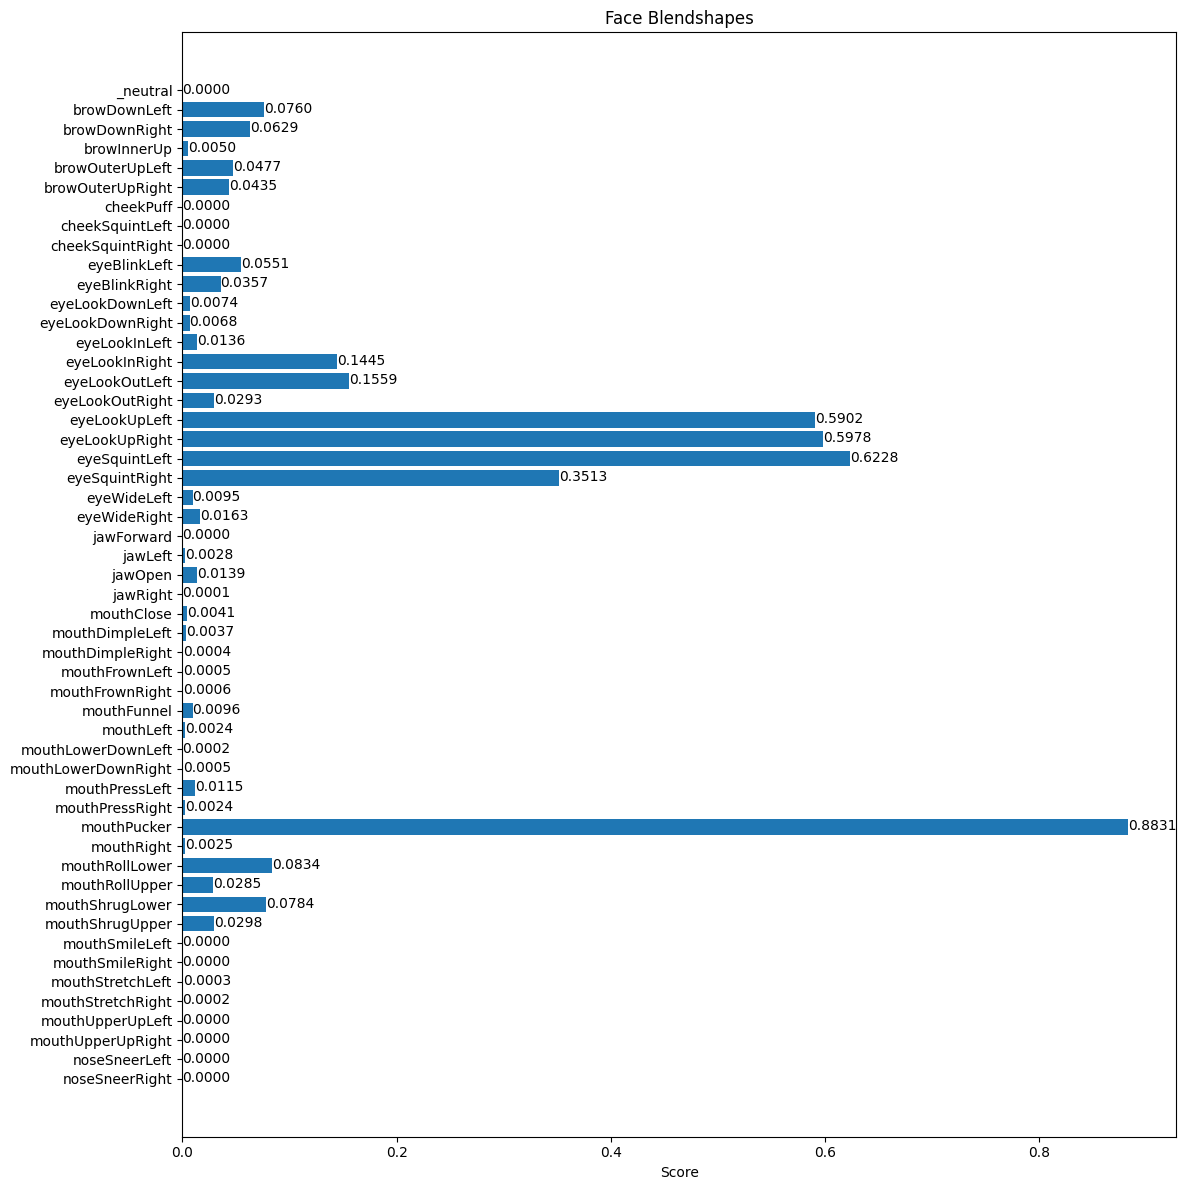

In [200]:
plot_face_blendshapes_bar_graph(detection_result.face_blendshapes[0])

In [208]:
# Process the detection result, visualize it
annotated_image = draw_landmarks_on_image(img.numpy_view(), detection_result)
cv2_imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR)


plt.imshow(cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
plt.show()

SyntaxError: invalid syntax (1479384356.py, line 6)